In [1]:
%matplotlib inline
# misc. libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ml libraries
from sklearn import cluster, metrics
from sklearn.decomposition import PCA

import inspect

%load_ext autoreload
%autoreload 2

In [231]:
# local dependencies
from helpers import *

+ **DHT:** Dihydrotestosterone is an endogenous androgen sex steroid and hormone
+ **E2:** Estradiol (E2), also spelled oestradiol, is an estrogen steroid hormone and the major female sex hormone
+ **P4:**  Progesterone (P4) is an endogenous steroid and progestogen sex hormone involved in the menstrual cycle, pregnancy, and embryogenesis of humans and other species

***
**Data loading**
***

In [224]:
# Raw information about genes
genes = load_genes()
genes.head(2)

dht           e2                  p4       
     up    down   up        down      up   down
0  KLK3    CPB1  NTS        CPB1    KLK3  RAB31
1  GPC3  CITED1  DCX  AC062028.2  CXCL13    PGR

In [225]:
# Preprocessed list of genes
genes_list = load_genes_list()
genes_list.head(2)

,genes,dht,e2,p4,upregulated
0,ABCA13,False,False,True,True
1,AC062028.2,False,True,False,False


In [226]:
# Genes that express two hormones
genes_list[genes_list[["dht", "e2", "p4"]].sum(axis=1) == 2]

,genes,dht,e2,p4,upregulated
17,CPB1,True,True,False,False
20,CXCL13,True,False,True,True
46,HPGD,True,True,False,True
54,KLK3,True,False,True,True
60,MYBPC1,True,False,True,True
65,NTRK3,False,True,True,True
85,SLC26A3,True,False,True,True
101,UGT2B11,True,False,True,True


In [227]:
# Load TCGA patient data (first part)
patients = load_patients()
patients.head(2)

,ABCA13,ADAMTS1,ADAMTS8,ALB,ALOX15B,ATP1A2,BICD1,CACNA1H,CISH,CITED1,...,TNFAIP3,TP63,TPSG1,TSPAN8,UGT2B11,UGT2B28,ZBTB16,ZNF107,ZNF282,ZNF71
0,0.9925,1658.0928,30.7667,448.2673,397.3203,102.5556,187.2467,1772.8691,1333.2231,105.5330,...,1490.3647,1332.8922,2.9973,30.7667,30.1050,13.8946,17.8645,542.5523,733.1073,186.5851
1,3.8556,1251.3669,40.2699,4.2840,672.5936,46.6960,188.0692,679.8765,1311.7718,113.0985,...,928.3506,864.0900,299.8825,1.7136,13.7089,1.2852,509.8003,451.9658,1116.8481,193.2100


In [228]:
# Load TCGA patient data (second part)
patients2 = load_patients2()
patients2.head(2)

gene_id,ABCA13,ADAMTS1,ADAMTS8,ALB,ALOX15B,ATP1A2,BICD1,CACNA1H,CISH,CITED1,...,TNFAIP3,TP63,TPSG1,TSPAN8,UGT2B11,UGT2B28,ZBTB16,ZNF107,ZNF282,ZNF71
0,0.0000,234.0233,8.9611,10.3398,10.6844,14.1310,77.8929,131.3150,686.9050,37.2232,...,242.9845,24.1261,0.3447,4.4806,0.3447,0.3447,156.1304,1718.4689,992.6174,338.4550
1,1.6313,514.9538,6.5253,15.7694,36.4328,12.5068,51.1147,104.4046,566.6123,21.2072,...,540.5111,28.8200,0.0000,4.8940,26.9222,40.2393,4.3502,516.0413,1320.8265,243.0669


In [229]:
genes_not_found = list(set(genes_list.genes) - set(patients.columns))

print(f"Genes not found in the patients datasets:\n{genes_not_found}")

Genes not found in the patients datasets:
['SOCS2-AS1', 'AL591034.3', 'FAM217B', 'FAR2P3', 'RFLNA', 'BPIFA4P', 'CYP4F30P', 'CYP4F29P', 'RUBCNL', 'AC062028.2', 'ZNRF2P1', 'FAM92A', 'POTEJ', 'CYP4F62P', 'PIEZO2', 'FLNB-AS1', 'KLF2P3']


In [238]:
# Load PDX tumor data
pdx = load_pdx()
pdx.shape

(23, 91)

In [237]:
from helpers import *

In [239]:
pdx.head()

gene                      ABCA13   ADAMTS1   ADAMTS8       ALB   ALOX15B  \
treatment id                                                               
dht       t111_g2_m09   3.189617  7.923171  8.423222  7.117144  3.614543   
          t111_g2_m06   6.357327  6.265651  8.954985  5.686476  4.232740   
          t111_g2_m02   7.431527  3.189617  8.053738  3.189617  3.189617   
e2        pl015_g3_m25  8.587668  6.596610  3.505313  6.296377  5.397508   
          t111_g2_m12   3.189617  8.261285  4.067052  7.135662  4.197837   

gene                      ATP1A2      BICD1   CACNA1H      CISH    CITED1  \
treatment id                                                                
dht       t111_g2_m09   3.189617   5.325093  7.794179  7.166217  8.599720   
          t111_g2_m06   3.189617   6.872338  8.818340  9.442043  9.093016   
          t111_g2_m02   3.189617   8.053738  6.306352  7.145168  3.189617   
e2        pl015_g3_m25  5.299416  10.393886  4.487468  3.955433  3.635197   
          t111_g2_m12   3.189617   8.933856  3.701361  3.189617  5.901508   

gene                    ...   TNFAIP3       TP63      TPSG1    TSPAN8  \
treatment id            ...                                             
dht       t111_g2_m09   ...  4.493391   9.518162   6.694106  8.178994   
          t111_g2_m06   ...  4.232740  10.280245   8.395725  6.872338   
          t111_g2_m02   ...  3.189617  10.065067   9.244580  6.306352   
e2        pl015_g3_m25  ...  5.560317   3.734270  11.238769  8.015305   
          t111_g2_m12   ...  4.067052   7.426682   9.190337  9.484781   

gene                     UGT2B11   UGT2B28    ZBTB16    ZNF107    ZNF282  \
treatment id                                                               
dht       t111_g2_m09   5.823731  5.844421  8.941439  5.823731  6.540557   
          t111_g2_m06   7.659201  5.163905  8.834178  7.341522  4.232740   
          t111_g2_m02   8.053738  5.568833  8.716628  6.306352  6.786746   
e2        pl015_g3_m25  8.522010  5.913858  8.678549  3.505313  3.189617   
          t111_g2_m12   4.589124  5.579790  8.937275  4.197837  5.466152   

gene                       ZNF71  
treatment id                      
dht       t111_g2_m09   8.834605  
          t111_g2_m06   9.039379  
          t111_g2_m02   6.786746  
e2        pl015_g3_m25  3.734270  
          t111_g2_m12   4.067052  

[5 rows x 91 columns]

In [153]:
pdx.index.get_level_values('treatment').value_counts()

p4     11
e2      9
dht     3
Name: treatment, dtype: int64

In [154]:
pdx.loc['dht']

gene,TMEM176A,MAP3K14,ATP1A2,PLEKHO1,TP63,DCX,PGR,HSD17B2,SLC26A3,CRTAC1,...,PDE2A,MYBPC1,GREB1,ZNF107,CACNA1H,ZNF71,QRICH1,TAT,DIO2,UGT2B11
id,,,,,,,,,,,,,,,,,,,,,
t111_g2_m09,3.189617,7.923171,8.423222,7.117144,3.614543,3.189617,5.325093,7.794179,7.166217,8.599720,...,4.493391,9.518162,6.694106,8.178994,5.823731,5.844421,8.941439,5.823731,6.540557,8.834605
t111_g2_m06,6.357327,6.265651,8.954985,5.686476,4.232740,3.189617,6.872338,8.818340,9.442043,9.093016,...,4.232740,10.280245,8.395725,6.872338,7.659201,5.163905,8.834178,7.341522,4.232740,9.039379
t111_g2_m02,7.431527,3.189617,8.053738,3.189617,3.189617,3.189617,8.053738,6.306352,7.145168,3.189617,...,3.189617,10.065067,9.244580,6.306352,8.053738,5.568833,8.716628,6.306352,6.786746,6.786746


In [255]:
genes = list(pdx.columns)

***
**Exploratory data analysis**
***

In [257]:
def plot_corr(corr, filename='corr.png'):
    tril_abs_corr = np.abs(np.tril(corr, k=-1))

    plt.figure(figsize=(25, 25))

    heatmap = sns.heatmap(
        tril_abs_corr,
        square=True,
        linewidths=.005,
        xticklabels=genes,
        yticklabels=genes,
        mask=(tril_abs_corr == 0)  # mask cells with missing values
    )
    fig = heatmap.get_figure()
    fig.savefig(f"../data/{filename}")

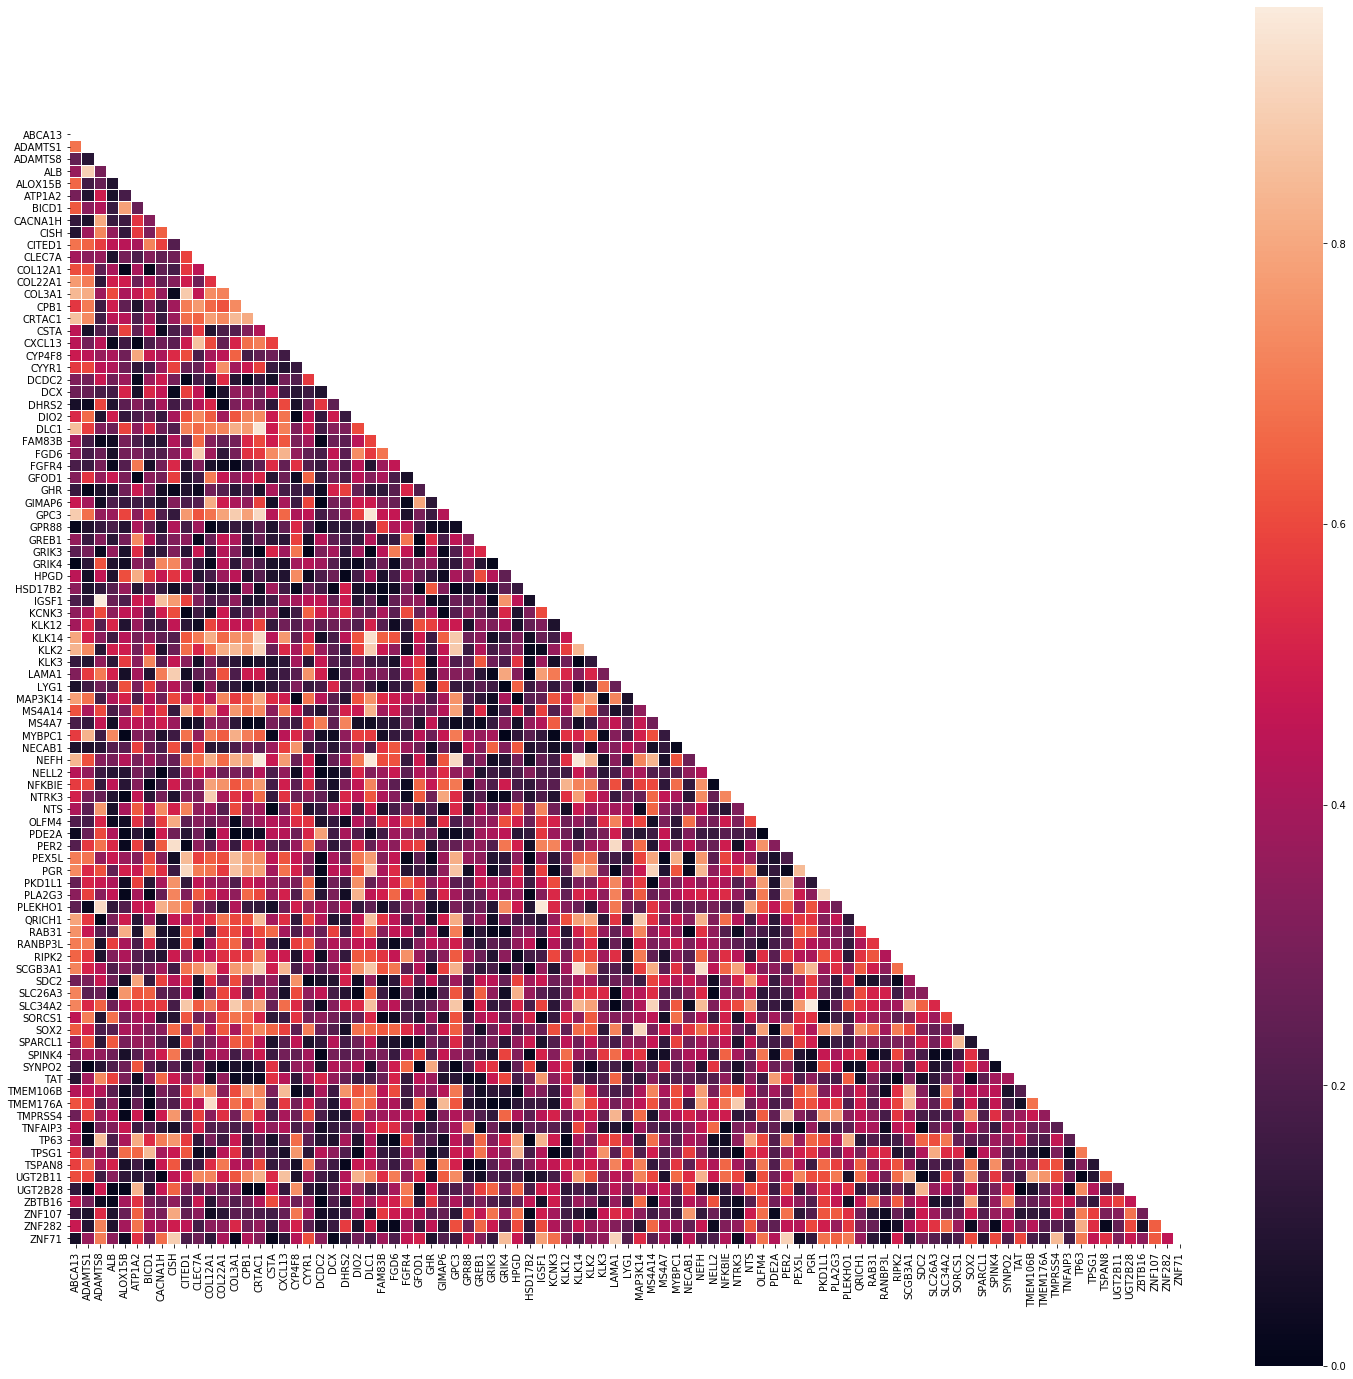

In [258]:
plot_corr(pdx.corr(), 'corr_pdx.png')

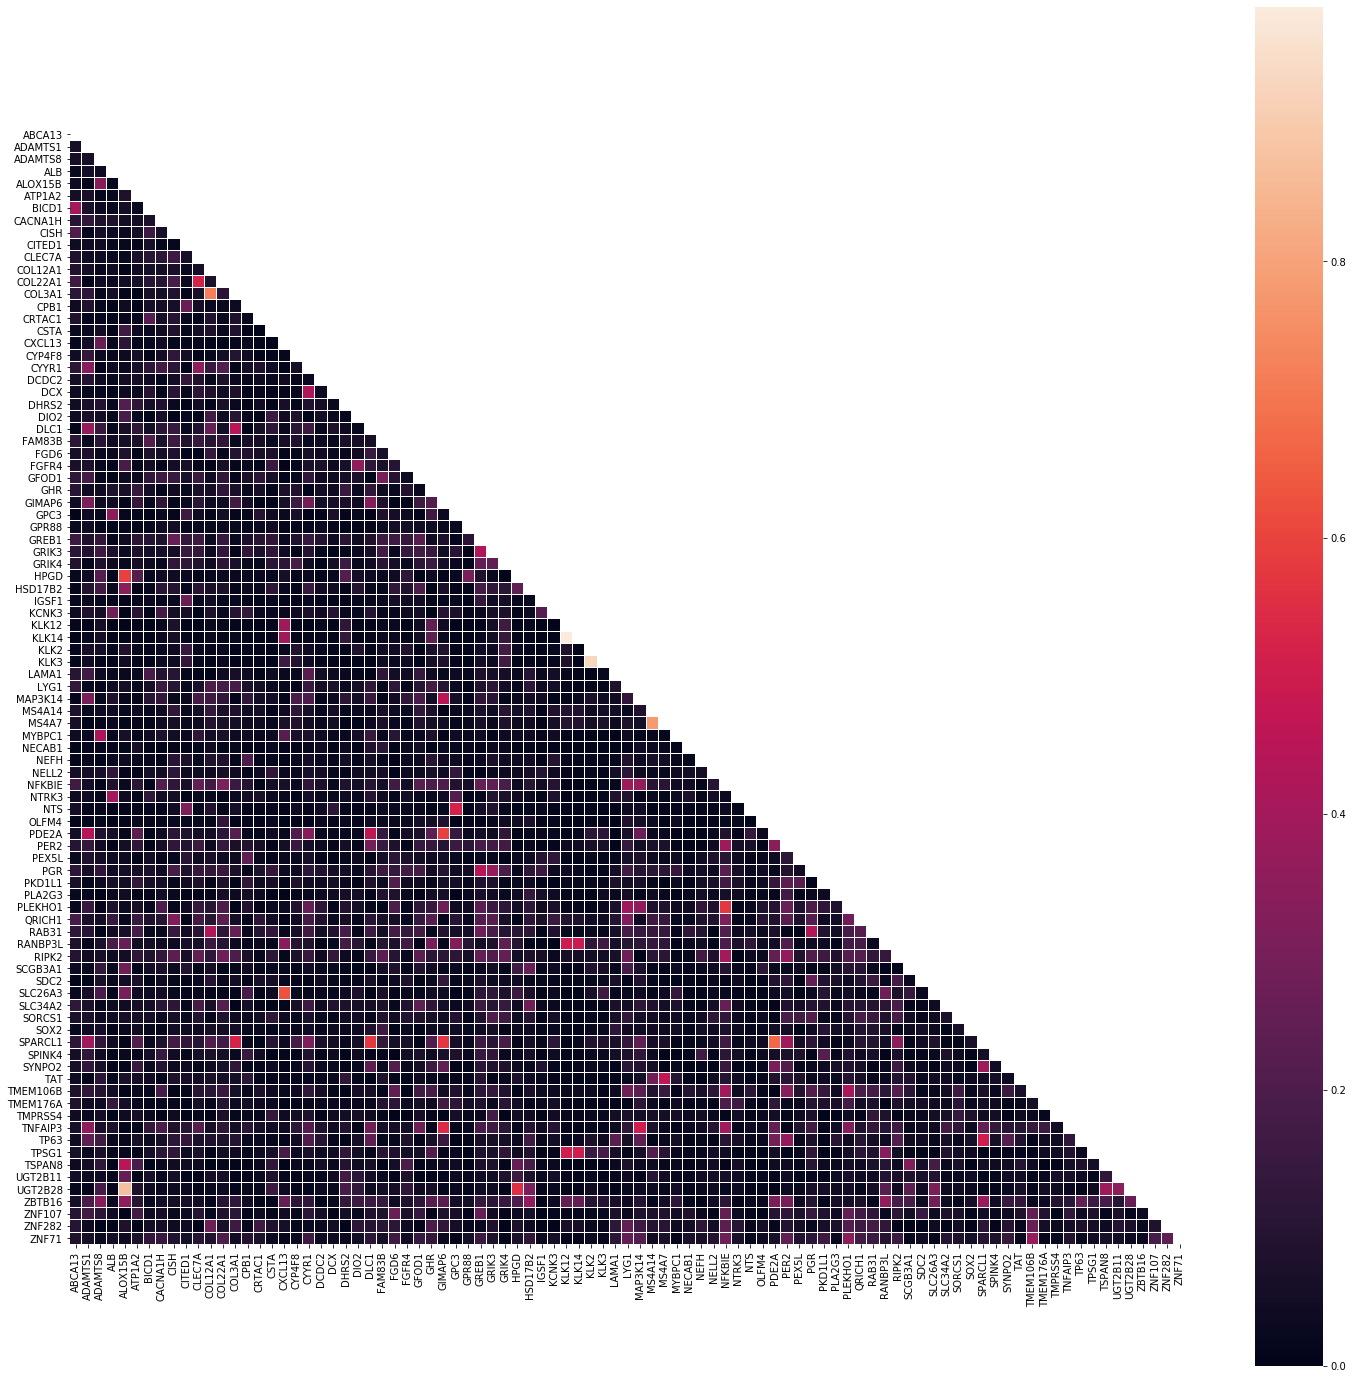

In [259]:
plot_corr(patients.corr(), 'corr_patients.png')

***
**Feature processing**
***

In [ ]:
# todo

***
**Clutering**
***

In [ ]:
clus = cluster.AgglomerativeClustering(n_clusters=2, affinity='manhattan', linkage='complete')
predicted = clus.fit_predict(pdx.transpose())
print(predicted)
accuracy, f2 = performance(predicted)

In [ ]:
def performance(labels):
    '''Evaluate performance of predicted cluster compared to pre-selected gene list'''
    # get gene list
    geneNP = genes_list.loc[:,'dht':'p4'].astype(int).values  # replace with Boolean values
    
    nb_clusters = len(np.unique(labels))
    accuracy = np.zeros([nb_clusters, 3])
    f2 =  np.zeros([nb_clusters, 3])
    beta = 2
    for i in np.arange(nb_clusters):
        label = np.zeros_like(labels)
        label[labels == i] = 1
        for j in np.arange(geneNP.shape[1]):
            # plot confusion matrices
            
            #cm = metrics.confusion_matrix(geneNP[:,j], label)
            #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            #fig, ax = plt.subplots()
            #im = ax.imshow(cm, interpolation='nearest')
            #ax.figure.colorbar(im, ax=ax)
            accuracy[i,j] = np.mean(geneNP[:,j]==label)
            f2[i,j] = metrics.fbeta_score(geneNP[:,j], label, beta)
    return accuracy, f2
        

In [ ]:
# PCA decomposition of original gene list
# we want to verify that the pre-selected genes are linearly independent

pca = PCA()
pca.fit(genes_list)
PCA(copy=True, iterated_power='auto', n_components=None,
    random_state=None, svd_solver='auto', tol=0.0, whiten=False)

# Explained variance by PCA
# print(pca.explained_variance_)

# Singular values of PCA
# print(pca.singular_values_)

y_pos = np.arange(len(pca.singular_values_))
plt.bar(y_pos, pca.singular_values_, align='center', alpha=0.5)
plt.ylabel('Values')
plt.xlabel('Principal components')
plt.title('PCA - Singular values')
plt.show()

#
#pca.n_components = 2
#X_reduced = pca.fit_transform(X)
# X_reduced.shape